In [1]:
from rdkit import RDLogger

logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL)

In [7]:
import pandas as pd
from thesis_work.utils import get_largest_fragment_from_smiles
from thesis_work.chemberta.model_descriptors import gen_embeddings
from thesis_work.chemberta.model_descriptors import (
    add_model_descriptor_to_df,
    initialize_model_tokenizer,
)

import seaborn as sns
import matplotlib.pyplot as plt
import umap

## Data

In [3]:
# Read in data from MoleculeNet
bbbp = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv")

# Clean up columnn names so they are easier to interpret
bbbp = (
    bbbp[["smiles", "p_np", "name"]]
    .reset_index(drop=True)
    .rename({"p_np": "permeable"}, axis=1)
)

# Remove extra fragments in SMILES (typically salts, which are irrelevant to BBB permeability)
bbbp["smiles"] = (
    bbbp["smiles"].apply(get_largest_fragment_from_smiles).dropna().astype(str)
)

# convert to str list
smiles = bbbp["smiles"].astype(str).tolist()
len(smiles)

2050

## Model Embeddings

In [4]:
# bert_loves_chemistry version

model_name = "DeepChem/ChemBERTa-77M-MLM"
model, tokenizer = initialize_model_tokenizer(model_name=model_name)

bpe_sentence_embeddings = gen_embeddings(
    model=model, tokenizer=tokenizer, smiles=smiles
)
bpe_sentence_embeddings.shape

Some weights of the model checkpoint at DeepChem/ChemBERTa-77M-MLM were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be 

tensor([[-0.0445, -0.0865, -0.0628,  ...,  0.0470, -0.0275, -0.2222],
        [-0.0148, -0.1321, -0.0600,  ..., -0.0350,  0.0104, -0.2393],
        [ 0.1048, -0.0729, -0.0169,  ..., -0.0696,  0.0517, -0.0299],
        ...,
        [-0.0693, -0.0691, -0.0553,  ...,  0.1044, -0.0899, -0.1897],
        [-0.1108,  0.0055,  0.0241,  ...,  0.0043,  0.1526, -0.1149],
        [ 0.0702, -0.0591, -0.1468,  ...,  0.1467, -0.0389, -0.1381]])

In [13]:
# my version - same as selformer

model, tokenizer = initialize_model_tokenizer(model_name=model_name)
result_df = add_model_descriptor_to_df(df=bbbp, model_name=model_name)
bpe_sentence_embeddings = result_df["vector"].tolist()

Some weights of the model checkpoint at DeepChem/ChemBERTa-77M-MLM were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be 

0       [-0.04445807635784149, -0.08652991056442261, -...
1       [-0.014786573126912117, -0.13210172951221466, ...
2       [0.10481903702020645, -0.07289864867925644, -0...
3       [-0.0899430438876152, -0.08043573796749115, -0...
4       [0.10401453822851181, 0.0699298232793808, -0.0...
                              ...                        
2045    [0.10738597065210342, 0.06204453855752945, -0....
2046    [0.034655675292015076, 0.008228685706853867, -...
2047    [-0.06926815211772919, -0.06912937015295029, -...
2048    [-0.11084797978401184, 0.0055059632286429405, ...
2049    [0.070186085999012, -0.0591079443693161, -0.14...
Name: vector, Length: 2050, dtype: object

## K-Means


In [ ]:
# from sklearn.cluster import KMeans
# import numpy as np

# # Set the number of clusters you want to create
# num_clusters = 2

# # Apply k-means clustering
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# cluster_labels = kmeans.fit_predict(model_embeddings)

# # Print the clustering results
# for cluster_id in range(num_clusters):
#     print(f"Cluster {cluster_id + 1}:")
#     cluster_text_indices = np.where(cluster_labels == cluster_id)[0]
#     for index in cluster_text_indices:
#         print(smiles[index])
#     print("\n")

## UMAP

- [bert-loves-chemisrty example](https://github.com/seyonechithrananda/bert-loves-chemistry/blob/master/chemberta/visualization/ChemBERTA_dimensionaliy_reduction_BBBP.ipynb)


In [15]:
n_neighbors = 50

In [16]:
%%time

# embed with umap
umap_model = umap.UMAP(
    metric="jaccard",
    n_neighbors=n_neighbors,
    n_components=2,
    low_memory=False,
    min_dist=0.001,
)
X_umap = umap_model.fit_transform(bpe_sentence_embeddings)
bbbp["BPE_UMAP_0"], bbbp["BPE_UMAP_1"] = X_umap[:, 0], X_umap[:, 1]

/home/ilker/miniconda3/envs/thesis-work/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


CPU times: user 2min 40s, sys: 1.17 s, total: 2min 41s
Wall time: 18.3 s


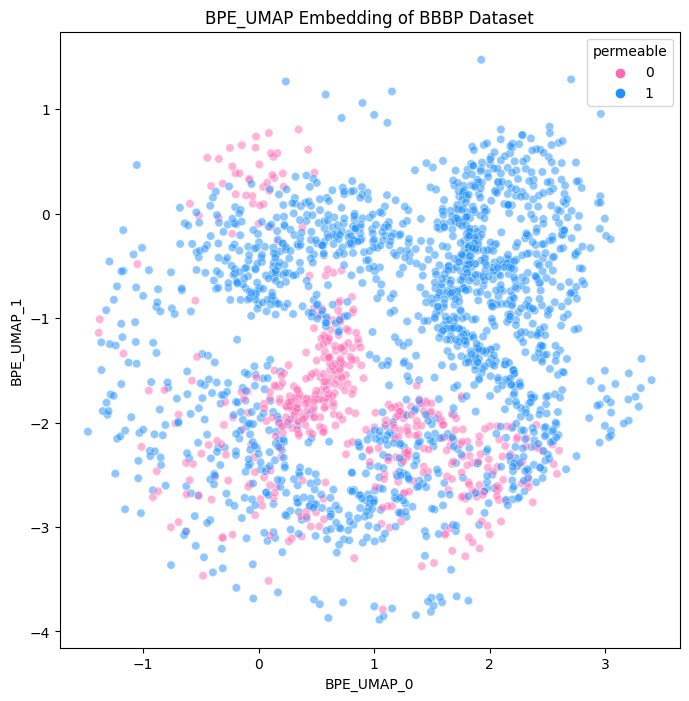

In [16]:
# Bert_loves_chemistry

palette = sns.color_palette(["hotpink", "dodgerblue"])

methods = ["BPE_UMAP", "st_UMAP", "ecfp_UMAP"]
methods = ["BPE_UMAP"]

for method in methods:
    plt.figure(figsize=(8, 8))
    sns.scatterplot(
        data=bbbp,
        x=f"{method}_0",
        y=f"{method}_1",
        hue="permeable",
        alpha=0.5,
        palette=palette,
    )
    plt.title(f"{method} Embedding of BBBP Dataset")
    plt.show()

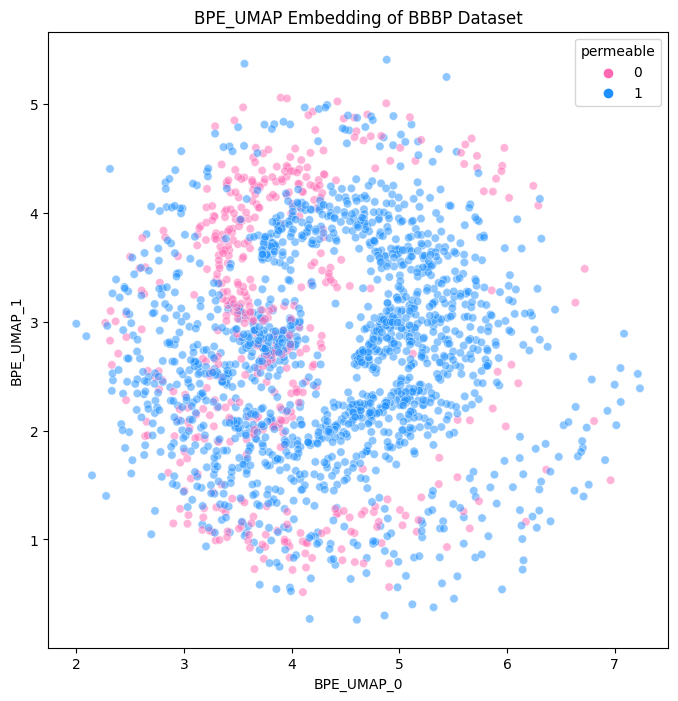

In [17]:
# My

palette = sns.color_palette(["hotpink", "dodgerblue"])

methods = ["BPE_UMAP", "st_UMAP", "ecfp_UMAP"]
methods = ["BPE_UMAP"]

for method in methods:
    plt.figure(figsize=(8, 8))
    sns.scatterplot(
        data=bbbp,
        x=f"{method}_0",
        y=f"{method}_1",
        hue="permeable",
        alpha=0.5,
        palette=palette,
    )
    plt.title(f"{method} Embedding of BBBP Dataset")
    plt.show()